# DSNet:  Automatic Dermoscopic Skin Lesion Segmentation


* Through  this  study,  we  present  a  new  and  automatic  semantic  segmentation  network for robust skin lesion segmentation named Dermoscopic Skin Network (DSNet).

* In order to reduce the number of parameters to make the network lightweight, we used a depth-wise separable convolution in lieu of standard convolution to project the learnt discriminating features onto the pixel space at different stages of the encoder.

* For any query: 
        ** Md. Kamrul Hasan 
        ** M.Sc. in Medical Imaging and Applications (MAIA)
        ** Erasmus Scholar [2017-2019] 
        ** Contact: kamruleeekuet@gmail.com

## Import all the python Packages 

In [16]:
#------------------------------Keras Packages----------------------------------- 
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *
from keras import backend as keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.densenet import DenseNet201, DenseNet121
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model#
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K



#------------------------------Others python Packages---------------------------
import numpy as np # High-level mathematical functions for n-dimensional arrays 
import os   
import cv2
import skimage.io as io
import skimage.transform as trans
import numpy as np
import glob
from PIL import Image
import skimage
from keras.initializers import Constant
from matplotlib import pyplot as plt
%matplotlib inline
from skimage.morphology import disk
from sklearn.metrics import confusion_matrix
from skimage.measure import label, regionprops
from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import jaccard_score

## Designing of Proposed DSNet

In [2]:
def DSNet(nClasses, input_height, input_width):

    #------------------------------Define Input Shape----------------------------------
    
    img_input = Input(shape=(input_height, input_width, 3)) # defining the Input shape 
    
    #Load DenseNet121 from keras. This model is initialized with the ImageNet. 
    #This part is responsible for the feature extraction which is so called convolution
    # part of the semantic segmentation (Encoder). 
    
    Encoder_Dense = DenseNet121( weights = 'imagenet',
						include_top = False,
						input_tensor = img_input) 

    Encoder = SeparableConv2D(filters = 1024,
					kernel_size = (3, 3),
					activation = 'relu',
					kernel_initializer='he_normal',
					padding="same")(Encoder_Dense.output)
    Encoder = BatchNormalization()(Encoder)

    
    # Decoding the encoded features to reconstruct the original input shape Image.

    Decoder = UpSampling2D(size = (2, 2))(Encoder)
    Decoder = concatenate([Encoder_Dense.get_layer(name="pool3_pool").output, Decoder], axis=-1)
    Decoder = SeparableConv2D(filters = 1024,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)
    
    Decoder = UpSampling2D(size = (2, 2))(Decoder)
    Decoder = concatenate([Encoder_Dense.get_layer(name="pool2_pool").output, Decoder], axis=-1)
    Decoder = SeparableConv2D(filters = 512,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)

    Decoder = UpSampling2D(size = (2, 2))(Decoder)
    Decoder = concatenate([Encoder_Dense.get_layer(name="pool1").output, Decoder], axis=-1)
    Decoder = SeparableConv2D(filters = 256,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)

    Decoder = UpSampling2D( size = (2, 2))(Decoder)
    Decoder = concatenate([Encoder_Dense.get_layer(name="conv1/bn").output, Decoder], axis=-1)
    Decoder = SeparableConv2D(filters = 128,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)

    Decoder = UpSampling2D(size = (2, 2))(Decoder)    
    Decoder = SeparableConv2D(filters = 64,
						kernel_size = (3, 3),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)

    Decoder = SeparableConv2D(filters = nClasses,
						kernel_size = (1, 1),
						activation = 'relu',
						kernel_initializer='he_normal',
						padding = "same")(Decoder)
    Decoder = BatchNormalization()(Decoder)
    

    Predicted_Mask = Conv2D(filters = 1,
									kernel_size = 1,
									activation = 'sigmoid')(Decoder)
    
    
    DSNet_model = Model(img_input,Predicted_Mask)###

    return DSNet_model

## Data Pre-processing 

In [3]:
def DataPreProcessing(img, mask):
    img = preprocess_input(img) # Data standardization meaning 0 mean and unit variance.
    img = img/img.max()         # Data Normalization
    mask = mask/mask.max()      # Mask Normalization
    return (img, mask)          # Return Tuple of Original image along with GT image. 

## Function for Train generator 

In [4]:
def trainGenerator(batch_size,
                   train_path,
                   image_folder,
                   mask_folder,
                   aug_dict,
                   image_color_mode = "rgb",
                   mask_color_mode = "grayscale",
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   save_to_dir = None,
                   target_size = (192,256),
                   seed = 1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = 'rgb',
        target_size = target_size,
        batch_size = batch_size,
#         save_to_dir = save_to_dir,
#         save_prefix  = image_save_prefix,
        seed = seed)

    
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = 'grayscale',
        target_size = target_size,
        batch_size = batch_size,
#         save_to_dir = save_to_dir,
#         save_prefix  = mask_save_prefix,
        seed = seed)

    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator:
        img,mask = DataPreProcessing(img,mask)
        yield (img,mask)

## Function for Test and Validation generator 

In [5]:
def ValGenerator(batch_size,
                 val_path,
                 image_folder,
                 mask_folder,
                 target_size = (192,256),
                 seed = 1):
    
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_directory(
        val_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = 'rgb',
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)

    
    mask_generator = mask_datagen.flow_from_directory(
        val_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = 'grayscale',
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)

    
    val_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in val_generator:
        img,mask = DataPreProcessing(img,mask)
        yield (img,mask)

## Function for Loss

In [17]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def Jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

def Jaccard_coef_loss(y_true, y_pred):
    return (1-Jaccard_coef(y_true, y_pred))

def bcc_Jaccard_coef_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred)+(1-Jaccard_coef(y_true, y_pred)))

## Train and Validate the Model

In [20]:
# This is for the list of the augmentation (Geometric Augmentation). This 
# geometric augmentation will increase the numbers of training images to
# overcome over-fiting and curse of dimensionality. This will act as a online 
# aumentation that will help to reduce the memory consumtion during the 
# Trainig phase. If you want you can augment the images before and save it to
# the directory and read them.

data_gen_args = dict(rotation_range=90,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='wrap')

CurrentDirectory=os.getcwd()

height=256#192
width=256

# Calling the train generator function with required arguments. 
TrainGen= trainGenerator(batch_size=12,
                         train_path=CurrentDirectory+'/isic-challenge-2016_split/',
                         image_folder='Input',
                         mask_folder='Mask',
                         aug_dict=data_gen_args,
                         image_color_mode = "grayscale",
                         mask_color_mode = "grayscale",
                         image_save_prefix  = "image",
                         mask_save_prefix  = "mask",
#                          save_to_dir = CurrentDirectory+'/aug/',
                         target_size = (height,width),
                         seed = 1)
 
# Calling the Validation/ Test generator function with required arguments. 
TestGen= ValGenerator(batch_size=12,
                      val_path=CurrentDirectory+'/isic-challenge-2016_split/',
                      image_folder='Val_Input', 
                      mask_folder='Val_Mask',
                      target_size = (height,width),
                      seed = 1)


# Calling the designed Model to train.

model = DSNet(2, height, width)

model.compile(optimizer = 'adadelta',
                loss = bcc_Jaccard_coef_loss,
                metrics = [Jaccard_coef])

# This will plot a graph of the model and save it to a file. 
plot_model(model, show_shapes=True, to_file='model.png')

# This will print the model summary and total parameters for each operations
# along with total learnable parameters.
model.summary()


# Save the model after every epoch. You can save only the best model. If the 
# specified metric do not improve it will not save the that current epoch. 

model_checkpoint = ModelCheckpoint('Trained_Model.hdf5',
                                   monitor='val_Jaccard_coef',
                                   verbose=1,
                                   mode='max',
                                   save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_Jaccard_coef',
                              factor=0.5,
                              patience=8,
                              verbose=1,
                              mode='max',
                              min_lr=0.00000001)

early_stopping = EarlyStopping(monitor='val_Jaccard_coef',
                               patience=5,
                               verbose=1,
                               mode='max',
                               restore_best_weights=True)


# Trains the model on data generated batch-by-batch by a Python generator 
# (or an instance of Sequence). The generator is run in parallel to the model,
# for efficiency. For instance, this allows you to do real-time data
# augmentation on images on CPU in parallel to training your model on GPU.


# history=model.fit_generator(TrainGen, 
#                             steps_per_epoch=400, 
#                             epochs=200, 
#                             verbose=1, 
#                             validation_data= TestGen, 
#                             validation_steps=30, 
#                             callbacks=[model_checkpoint, reduce_lr])


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 262, 262, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)         

 ization)                                                                                         
                                                                                                  
 conv2_block4_0_relu (Activatio  (None, 64, 64, 160)  0          ['conv2_block4_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 64, 64, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 64, 64, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_0_bn (BatchNormal  (None, 32, 32, 160)  640        ['conv3_block1_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_0_relu (Activatio  (None, 32, 32, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 32, 32, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv3_block6_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 32, 32, 320)  0          ['conv3_block5_concat[0][0]',    
 te)      

 conv3_block10_2_conv (Conv2D)  (None, 32, 32, 32)   36864       ['conv3_block10_1_relu[0][0]']   
                                                                                                  
 conv3_block10_concat (Concaten  (None, 32, 32, 448)  0          ['conv3_block9_concat[0][0]',    
 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 32, 32, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 32, 32, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 32)   36864       ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_concat (Concatena  (None, 16, 16, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv4_block7_0_relu (Activatio  (None, 16, 16, 448)  0          ['conv4_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 16, 16, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block11_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block11_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 16, 16, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
          

                                                                                                  
 conv4_block15_concat (Concaten  (None, 16, 16, 736)  0          ['conv4_block14_concat[0][0]',   
 ate)                                                             'conv4_block15_2_conv[0][0]']   
                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 16, 16, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 16, 16, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block20_0_relu (Activati  (None, 16, 16, 864)  0          ['conv4_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 16, 16, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block24_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 16, 16, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 16, 16, 1024  4096        ['conv4_block24_concat[0][0]']   
          

                                                                                                  
 conv5_block4_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv5_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 8, 8, 640)   0           ['conv5_block3_concat[0][0]',    
 te)      

 conv5_block8_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv5_block8_1_relu[0][0]']    
                                                                                                  
 conv5_block8_concat (Concatena  (None, 8, 8, 768)   0           ['conv5_block7_concat[0][0]',    
 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 8, 8, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 8, 8, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block13_0_relu (Activati  (None, 8, 8, 896)   0           ['conv5_block13_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 8, 8, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 8, 8, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)      

                                                                                                  
 up_sampling2d_10 (UpSampling2D  (None, 16, 16, 1024  0          ['batch_normalization_14[0][0]'] 
 )                              )                                                                 
                                                                                                  
 concatenate_8 (Concatenate)    (None, 16, 16, 1280  0           ['pool3_pool[0][0]',             
                                )                                 'up_sampling2d_10[0][0]']       
                                                                                                  
 separable_conv2d_15 (Separable  (None, 16, 16, 1024  1323264    ['concatenate_8[0][0]']          
 Conv2D)                        )                                                                 
                                                                                                  
 batch_nor

In [21]:

history=model.fit_generator(TrainGen, 
                             steps_per_epoch=45, 
                             epochs=200, 
                             verbose=1, 
                             validation_data= TestGen, 
                             validation_steps=30, 
                             callbacks=[model_checkpoint, reduce_lr])

c:\users\yiang gong\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Found 540 images belonging to 1 classes.
Found 540 images belonging to 1 classes.
Epoch 1/200
45/45 [==============================] - ETA: 0s - loss: 1.7019 - Jaccard_coef: 0.2034Found 180 images belonging to 1 classes.
Found 180 images belonging to 1 classes.

Epoch 1: val_Jaccard_coef improved from -inf to 0.23789, saving model to Trained_Model.hdf5
45/45 [==============================] - 51s 965ms/step - loss: 1.7019 - Jaccard_coef: 0.2034 - val_loss: 1.4587 - val_Jaccard_coef: 0.2379 - lr: 0.0010
Epoch 2/200
45/45 [==============================] - ETA: 0s - loss: 1.6439 - Jaccard_coef: 0.2172
Epoch 2: val_Jaccard_coef did not improve from 0.23789
45/45 [==============================] - 41s 915ms/step - loss: 1.6439 - Jaccard_coef: 0.2172 - val_loss: 1.4642 - val_Jaccard_coef: 0.2365 - lr: 0.0010
Epoch 3/200
45/45 [==============================] - ETA: 0s - loss: 1.6021 - Jaccard_coef: 0.2285
Epoch 3: val_Jaccard_coef improved from 0.23789 to 0.23857, saving model to Trained_Mo

45/45 [==============================] - ETA: 0s - loss: 1.1759 - Jaccard_coef: 0.3712
Epoch 25: val_Jaccard_coef improved from 0.40964 to 0.41585, saving model to Trained_Model.hdf5
45/45 [==============================] - 46s 1s/step - loss: 1.1759 - Jaccard_coef: 0.3712 - val_loss: 1.1244 - val_Jaccard_coef: 0.4159 - lr: 0.0010
Epoch 26/200
45/45 [==============================] - ETA: 0s - loss: 1.1630 - Jaccard_coef: 0.3762
Epoch 26: val_Jaccard_coef improved from 0.41585 to 0.41996, saving model to Trained_Model.hdf5
45/45 [==============================] - 46s 1s/step - loss: 1.1630 - Jaccard_coef: 0.3762 - val_loss: 1.1269 - val_Jaccard_coef: 0.4200 - lr: 0.0010
Epoch 27/200
45/45 [==============================] - ETA: 0s - loss: 1.1474 - Jaccard_coef: 0.3829
Epoch 27: val_Jaccard_coef improved from 0.41996 to 0.42178, saving model to Trained_Model.hdf5
45/45 [==============================] - 46s 1s/step - loss: 1.1474 - Jaccard_coef: 0.3829 - val_loss: 1.1161 - val_Jaccard_c

Epoch 50/200
45/45 [==============================] - ETA: 0s - loss: 0.9761 - Jaccard_coef: 0.4500
Epoch 50: val_Jaccard_coef did not improve from 0.47234
45/45 [==============================] - 45s 1000ms/step - loss: 0.9761 - Jaccard_coef: 0.4500 - val_loss: 0.9759 - val_Jaccard_coef: 0.4718 - lr: 0.0010
Epoch 51/200
45/45 [==============================] - ETA: 0s - loss: 0.9730 - Jaccard_coef: 0.4507
Epoch 51: val_Jaccard_coef did not improve from 0.47234
45/45 [==============================] - 45s 1s/step - loss: 0.9730 - Jaccard_coef: 0.4507 - val_loss: 0.9793 - val_Jaccard_coef: 0.4686 - lr: 0.0010
Epoch 52/200
45/45 [==============================] - ETA: 0s - loss: 0.9746 - Jaccard_coef: 0.4498
Epoch 52: val_Jaccard_coef did not improve from 0.47234
45/45 [==============================] - 45s 1s/step - loss: 0.9746 - Jaccard_coef: 0.4498 - val_loss: 0.9702 - val_Jaccard_coef: 0.4706 - lr: 0.0010
Epoch 53/200
45/45 [==============================] - ETA: 0s - loss: 0.9860 -

45/45 [==============================] - 46s 1s/step - loss: 0.9109 - Jaccard_coef: 0.4731 - val_loss: 0.8798 - val_Jaccard_coef: 0.5093 - lr: 0.0010
Epoch 76/200
45/45 [==============================] - ETA: 0s - loss: 0.8867 - Jaccard_coef: 0.4846
Epoch 76: val_Jaccard_coef did not improve from 0.50926
45/45 [==============================] - 46s 1s/step - loss: 0.8867 - Jaccard_coef: 0.4846 - val_loss: 0.8789 - val_Jaccard_coef: 0.5071 - lr: 0.0010
Epoch 77/200
45/45 [==============================] - ETA: 0s - loss: 0.8873 - Jaccard_coef: 0.4837
Epoch 77: val_Jaccard_coef did not improve from 0.50926
45/45 [==============================] - 46s 1s/step - loss: 0.8873 - Jaccard_coef: 0.4837 - val_loss: 0.8751 - val_Jaccard_coef: 0.5089 - lr: 0.0010
Epoch 78/200
45/45 [==============================] - ETA: 0s - loss: 0.8860 - Jaccard_coef: 0.4856
Epoch 78: val_Jaccard_coef improved from 0.50926 to 0.51082, saving model to Trained_Model.hdf5
45/45 [==============================] - 4

45/45 [==============================] - ETA: 0s - loss: 0.8292 - Jaccard_coef: 0.5061
Epoch 101: val_Jaccard_coef improved from 0.53063 to 0.53974, saving model to Trained_Model.hdf5
45/45 [==============================] - 41s 924ms/step - loss: 0.8292 - Jaccard_coef: 0.5061 - val_loss: 0.8074 - val_Jaccard_coef: 0.5397 - lr: 0.0010
Epoch 102/200
45/45 [==============================] - ETA: 0s - loss: 0.8512 - Jaccard_coef: 0.4968
Epoch 102: val_Jaccard_coef did not improve from 0.53974
45/45 [==============================] - 40s 902ms/step - loss: 0.8512 - Jaccard_coef: 0.4968 - val_loss: 0.8252 - val_Jaccard_coef: 0.5212 - lr: 0.0010
Epoch 103/200
45/45 [==============================] - ETA: 0s - loss: 0.8428 - Jaccard_coef: 0.5005
Epoch 103: val_Jaccard_coef did not improve from 0.53974
45/45 [==============================] - 41s 903ms/step - loss: 0.8428 - Jaccard_coef: 0.5005 - val_loss: 0.8137 - val_Jaccard_coef: 0.5312 - lr: 0.0010
Epoch 104/200
45/45 [====================

Epoch 127/200
45/45 [==============================] - ETA: 0s - loss: 0.8040 - Jaccard_coef: 0.5148
Epoch 127: val_Jaccard_coef did not improve from 0.54618
45/45 [==============================] - 41s 919ms/step - loss: 0.8040 - Jaccard_coef: 0.5148 - val_loss: 0.7787 - val_Jaccard_coef: 0.5441 - lr: 5.0000e-04
Epoch 128/200
45/45 [==============================] - ETA: 0s - loss: 0.8048 - Jaccard_coef: 0.5142
Epoch 128: val_Jaccard_coef did not improve from 0.54618
45/45 [==============================] - 40s 902ms/step - loss: 0.8048 - Jaccard_coef: 0.5142 - val_loss: 0.7832 - val_Jaccard_coef: 0.5416 - lr: 5.0000e-04
Epoch 129/200
45/45 [==============================] - ETA: 0s - loss: 0.7936 - Jaccard_coef: 0.5207
Epoch 129: val_Jaccard_coef did not improve from 0.54618

Epoch 129: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
45/45 [==============================] - 41s 914ms/step - loss: 0.7936 - Jaccard_coef: 0.5207 - val_loss: 0.7825 - val_Jaccard_coef: 

45/45 [==============================] - ETA: 0s - loss: 0.8004 - Jaccard_coef: 0.5162
Epoch 152: val_Jaccard_coef did not improve from 0.54618
45/45 [==============================] - 46s 1s/step - loss: 0.8004 - Jaccard_coef: 0.5162 - val_loss: 0.7816 - val_Jaccard_coef: 0.5404 - lr: 6.2500e-05
Epoch 153/200
45/45 [==============================] - ETA: 0s - loss: 0.8037 - Jaccard_coef: 0.5161
Epoch 153: val_Jaccard_coef did not improve from 0.54618

Epoch 153: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
45/45 [==============================] - 45s 1s/step - loss: 0.8037 - Jaccard_coef: 0.5161 - val_loss: 0.7874 - val_Jaccard_coef: 0.5345 - lr: 6.2500e-05
Epoch 154/200
45/45 [==============================] - ETA: 0s - loss: 0.7992 - Jaccard_coef: 0.5172
Epoch 154: val_Jaccard_coef did not improve from 0.54618
45/45 [==============================] - 45s 1s/step - loss: 0.7992 - Jaccard_coef: 0.5172 - val_loss: 0.7847 - val_Jaccard_coef: 0.5423 - lr: 3.1250e-05

45/45 [==============================] - ETA: 0s - loss: 0.7984 - Jaccard_coef: 0.5177
Epoch 177: val_Jaccard_coef did not improve from 0.55028
45/45 [==============================] - 41s 917ms/step - loss: 0.7984 - Jaccard_coef: 0.5177 - val_loss: 0.7899 - val_Jaccard_coef: 0.5334 - lr: 7.8125e-06
Epoch 178/200
45/45 [==============================] - ETA: 0s - loss: 0.7957 - Jaccard_coef: 0.5179
Epoch 178: val_Jaccard_coef did not improve from 0.55028

Epoch 178: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
45/45 [==============================] - 43s 959ms/step - loss: 0.7957 - Jaccard_coef: 0.5179 - val_loss: 0.7844 - val_Jaccard_coef: 0.5342 - lr: 7.8125e-06
Epoch 179/200
45/45 [==============================] - ETA: 0s - loss: 0.7939 - Jaccard_coef: 0.5184
Epoch 179: val_Jaccard_coef improved from 0.55028 to 0.55067, saving model to Trained_Model.hdf5
45/45 [==============================] - 43s 948ms/step - loss: 0.7939 - Jaccard_coef: 0.5184 - val_loss: 0

## Plotting the train and validation performance

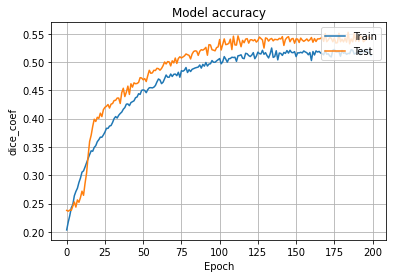

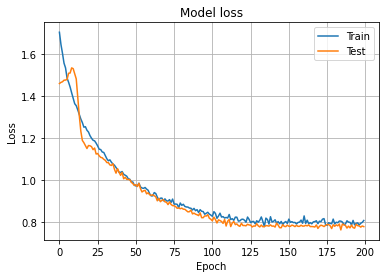

In [22]:
 # Plot training & validation accuracy values
plt.plot(history.history['Jaccard_coef'])
plt.plot(history.history['val_Jaccard_coef'])
plt.title('Model accuracy')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid('on')
plt.show()

 # Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid('on')
plt.show()

In [23]:
def Performance_Metrics(y_true, y_pred):
    ''' 
    The Dice similarity coefficient (DSC) is a statistical validation metric for the image
    segmentations and determines the spatial overlap accuracy of the segmentation. It also 
    same as F1-score. 
    
    The Intersection over Union (IoU) also referred to as the Jaccard index (JI), is essentially
    a method to quantify the percent overlap between the GT mask and prediction output.
    This metric is closely related to the DSC. The IoU metric measures the number of pixels
    common between the target and prediction masks divided by the total number of pixels present
    across both masks.
    
    Mathematically, they are related as follows:
    IoU = DSC/(2-DSC) or DSC = 2*IoU/(IoU+1)
    
    The Sensitivity also called the true positive rate, the recall, or probability of detection that 
    measures the proportion of actual positives that are correctly identified as such class 
    (e.g., the percentage of sick people who are correctly identified as having the condition).
    
    The Specificity also called the true negative rate measures the proportion of actual negatives that
    are correctly identified as such class. (e.g., the percentage of healthy people who are correctly
    identified as not having the condition).
    
  
    Input Arguments: 
        y_true: True Labels of the 2D images so called ground truth (GT).
        y_pred: Predicted Labels of the 2D images so called Predicted/ segmented Mask.
        
    Output Arguments: 
        dsc: The DSC between y_true and y_pred
        iou: The IoU between y_true and y_pred
        accuracy: The accuracy of pixels clasification.
        sensitivity: The accuracy of foreground pixels clasification.
        specificity: The accuracy of background pixels clasification.
        balancedAccuracy: The balanced accuracy of both foreground & background pixels clasification.
        
    Author: Md. Kamrul Hasan, 
            Erasmus Scholar on Medical Imaging and Application (MAIA)
            E-mail: kamruleeekuet@gmail.com

    '''
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch!! y_true and y_pred must have the same shape.")

    y_true_f = (y_true/y_true.max()).flatten()
    y_pred_f = (y_pred/y_pred.max()).flatten()
    
    intersection = np.sum(y_true_f * y_pred_f)
    
    dsc = (2. * intersection ) / (np.sum(y_true_f) + np.sum(y_pred_f))
    iou = (intersection) / (np.sum(y_true_f) + np.sum(y_pred_f)-intersection)
    
    y_true = np.asarray(y_true).astype(np.bool)
    y_pred = np.asarray(y_pred).astype(np.bool)

        
    y_true=y_true.flatten()
    y_pred=y_pred.flatten()
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tn+tp)/(tn+fp+fn+tp)
    sensitivity = (tp)/(fn+tp)
    specificity = (tn)/(tn+fp)
    balancedAccuracy = (sensitivity+specificity)/2

    
    return dsc, iou, accuracy, sensitivity, specificity, balancedAccuracy

## Mask Prediction from DSNet

In [26]:
# Predict the masks using the proposed DSNet and those masks are processed using 
# the “DSNet_Performance.m” to estimate the performance metrics. The ROC curves 
# are plotted using the “ROC_DSNet.ipynb” 

testImagePath =CurrentDirectory+"/isic-challenge-2016_split/Test_Input"
imagePath = glob.glob(testImagePath+"*.jpg")
imagePath.sort()
print(len(imagePath))

GTPath= CurrentDirectory+"/isic-challenge-2016_split/Test_Mask"
GT = glob.glob(GTPath+"*.png")
GT.sort()
print(len(GT))


MaskSavePath= CurrentDirectory+'/isic-challenge-2016_split/Output_Mask'

model = DSNet(2, height, width)

model.load_weights("Trained_Model.hdf5")

for imageName,gt in zip(imagePath,GT):
    img = cv2.imread(imageName,-1)
    imgcopy=img.copy()
    filename, file_extension = os.path.splitext(imageName) 
    
    img=cv2.resize(img,(width,height))
    img=img.astype(np.float32)
    img = img/img.max()
    img=np.expand_dims(img, axis=0)
    Prediction=model.predict(img,verbose=0)
    
    mask=Prediction.reshape(height,width)
    mask=(255*(mask/mask.max())).astype('uint8')
    cv2.imwrite(MaskSavePath+filename[-12:]+'.png',mask)

0
0
